## Automated ML

### 全体の流れ
1. モジュールのインポート  
2. 定数の設定  
3. データセットの読み込み  
4. EDA(データを知る)  
    欠損値の確認  
    各データのタイプ確認  
5. 学習用データセットの作成  
    5-1. ohe-encoding  
    5-2. 欠損値補完  
    5-3. 次元圧縮、特徴量選択  
    (5-4. 不均衡データへの対応)  
6. Pipelineの設定  
    6-1. Pipelineの定義  
    6-2. Grid Search用のパラメータ定義  
7. 学習  
8. モデル選定  
9. 全データを使った学習  
10. スコアリング用のデータ作成  
    10-1. スコアリング用のデータの読み出し  
    10-2. one-hot-encoding処理  
    10-3. one-hot encoding後のデータ整合チェック  
    10-4. one-hot-encoding後のデータ不整合の解消  
    10-5. データ項目の並び順の担保  
    10-6. 欠損値処理  
    10-7. 次元圧縮、特徴量選択
11. 推論  
12. 提出用データ(CSVファイル）の作成  

<未実装>
- カテゴリ変数の自動判別 -> 手動で設定
- 推論対象データの自動判別 -> 手動で設定
- 訓練データ/テストデータの自動判別 -> 手動で設定

### 1. モジュール類のインポート

In [3]:
# データ解析のライブラリ
import numpy as np
import pandas as pd
import os
import pickle
import time

# 評価手法
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 欠損値補完
from sklearn.impute import SimpleImputer

# 次元圧縮
from sklearn.feature_selection import RFE

# 学習手法
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

 # 指標の選択
from ipywidgets import interact,interactive,fixed,interact_manual
from IPython.display import display
import ipywidgets as widgets

In [4]:
# 表示オプションの変更
pd.options.display.max_columns = 50

### 2. 定数の設定

データセットの指定

In [5]:
# ダミーファイル（事前動作確認用）
train_file = '../data/final_hr_analysis_train.csv'
test_file = '../data/final_hr_analysis_test.csv'

提出ファイル

In [6]:
submit_file_dir = '../submit/'
submit_file_name = 'submit.csv'

提出ファイル作成時のIDのカラム

In [7]:
ID_column = 'index'

教師データ（推論の対象データ）の設定

In [8]:
target_value = 'left'

データセットに関する設定（カテゴリ変数）

In [15]:
# カテゴリ変数をリストで設定
ohe_columns = ['sales', 'salary',]

# 設定したカテゴリリストをkeyに、valueはobjectを設定する(リストから辞書を作成)
my_dtype = {k: object  for k in ohe_columns}

In [16]:
print(my_dtype)

{'sales': <class 'object'>, 'salary': <class 'object'>}


訓練データ/テストデータから除外するカラムリスト

In [17]:
# 除外リスト
score_reject_items =[ID_column]
train_reject_items = score_reject_items + [target_value]

### 3. データセットの読み込み

In [18]:
# csvファイルからの読み出し
dataset = pd.read_csv(train_file,
                     header=0,    # CSVデータの1行目が見出し(header)で有ることを指定。データは1行目が[0]
                     dtype=my_dtype)

# 1列目のID情報、推論対象は特徴量から削除
# pandas.core.frame.DataFrame
X = pd.DataFrame(dataset).drop(columns=train_reject_items, axis=1)

# pandas.core.series.Series
y = pd.Series(dataset[target_value])

# 形状の確認
# check the shape
print('----------------------------------------------------------------')
print('X shape: (%i,%i)' %X.shape)
print('----------------------------------------------------------------')
print('y shape: (%i,)' %y.shape)
print('----------------------------------------------------------------')
print(y.value_counts())
print('left（1：退職、0：非退職の正解ラベル）')
print('----------------------------------------------------------------')
print()
print('dataset:csvファイル生データ')
display(dataset.head())
print('X:訓練データセット')
X.join(y).head()

----------------------------------------------------------------
X shape: (10499,9)
----------------------------------------------------------------
y shape: (10499,)
----------------------------------------------------------------
0    7966
1    2533
Name: left, dtype: int64
left（1：退職、0：非退職の正解ラベル）
----------------------------------------------------------------

dataset:csvファイル生データ


,index,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,10438,0,0.53,0.52,2,135,4,0,0,technical,medium
1,9236,0,0.77,0.53,5,256,3,0,0,accounting,medium
2,818,1,0.89,0.79,3,149,2,0,0,support,medium
3,11503,0,0.64,0.63,3,156,6,1,0,support,low
4,11721,0,0.98,0.74,4,151,3,0,0,sales,medium


X:訓練データセット


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.53,0.52,2,135,4,0,0,technical,medium,0
1,0.77,0.53,5,256,3,0,0,accounting,medium,0
2,0.89,0.79,3,149,2,0,0,support,medium,1
3,0.64,0.63,3,156,6,1,0,support,low,0
4,0.98,0.74,4,151,3,0,0,sales,medium,0


### 4. EDA

In [19]:
# 欠損値の確認
dataset.isnull().sum()

index                    0
left                     0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [20]:
# 各データ型を表示
dataset.dtypes

index                      int64
left                       int64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

### 5. データセットの作成

#### 5-1. カテゴリカル変数⇒one-hotエンコード  
選択したcolumnに対してone-hot encoding処理を行う

In [21]:
def one_hot_encoding(data, ohe_columns):
    X_ohe = pd.get_dummies(data,
                       dummy_na=True,    # 欠損値もダミー化
                       columns=ohe_columns)
    print('X_ohe shape:(%i,%i)' % X_ohe.shape)
    display(X_ohe.head())
    return X_ohe
    
X_ohe = one_hot_encoding(X, ohe_columns)

X_ohe shape:(10499,22)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan
0,0.53,0.52,2,135,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.77,0.53,5,256,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0.89,0.79,3,149,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.64,0.63,3,156,6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0.98,0.74,4,151,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### 5-2. 数値変数の欠損値対応
1. 平均値をオリジナルのデータを使って計算する。（fit）   
2. impに設定した平均値で、モデルに読み込むデータの欠損値を処理する。    
※ (注意)test用のデータでは、訓練用に計算した平均値データを使って、欠損値を処理する。(test用のデータの平均値を使わない)

In [22]:
def imputing_nan(X_ohe_for_training, X_ohe_apply_to):
    
    imp = SimpleImputer()    # default設定で平均値
    imp.fit(X_ohe_for_training)             # impにて計算するデータ
    
    X_ohe_columns =  X_ohe_for_training.columns.values
    X_ohe = pd.DataFrame(imp.transform(X_ohe_apply_to), columns=X_ohe_columns)
    display(X_ohe.head())
    return X_ohe,  X_ohe_columns, imp

X_ohe, X_ohe_columns, imp = imputing_nan(X_ohe, X_ohe)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan
0,0.53,0.52,2.0,135.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.77,0.53,5.0,256.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.89,0.79,3.0,149.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.64,0.63,3.0,156.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.98,0.74,4.0,151.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
X_ohe.shape

(10499, 22)

#### 5-3. 次元圧縮(特徴量選択)

モデル用データの前処理：次元圧縮（特徴量選択）  
RFEによる特徴量選択を実施します。

In [24]:
def dimension_compression(X_ohe, y):
    selector = RFE(RandomForestClassifier(n_estimators=100, random_state=1),
               n_features_to_select=15, # 圧縮後の次元数
               step=.05)
    selector.fit(X_ohe,y)
    X_ohe_columns =  X_ohe.columns.values
    # 学習用のデータセットを処理
    # selector.support_には、True/Falseのリストとなっている
    X_fin = X_ohe.loc[:, X_ohe_columns[selector.support_]]
    print('X_fin shape:(%i,%i)' % X_fin.shape)
    display(X_fin.head())
    return X_fin, selector
    
X_fin, selector = dimension_compression(X_ohe, y)

X_fin shape:(10499,15)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,sales_IT,sales_RandD,sales_accounting,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.53,0.52,2.0,135.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.77,0.53,5.0,256.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.89,0.79,3.0,149.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.64,0.63,3.0,156.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.98,0.74,4.0,151.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [25]:
print('-----------------------------------')
print('X_fin shape: (%i,%i)' %X_fin.shape)
print('-----------------------------------')
print(y.value_counts())
print('--------------------------------------------------')
print('y=0 means Not survived,　y=1 Survived(生存):')
print('--------------------------------------------------')
print('y shape: (%i,)' %y.shape)
print('--------------------------------------------------')

-----------------------------------
X_fin shape: (10499,15)
-----------------------------------
0    7966
1    2533
Name: left, dtype: int64
--------------------------------------------------
y=0 means Not survived,　y=1 Survived(生存):
--------------------------------------------------
y shape: (10499,)
--------------------------------------------------


#### 5-4. 不均衡データへの対応
(未実装)

### 6. Pipelineの設定  
#### 6-1. Pipelineの定義

In [26]:
# set pipelines for different algorithms
# ディクショナリー型のpipelinesに、モデル名をkey、値にpipelineのリストを登録
pipelines = {
    'knn':
        Pipeline([('scl',StandardScaler()),
                    ('est',KNeighborsClassifier())]),
    # ロジスティック回帰
    'logistic':
        Pipeline([('scl',StandardScaler()),
                    ('est',LogisticRegression(random_state=1))]),
    'rsvc':
        Pipeline([('scl',StandardScaler()),
                    ('est',SVC(C=1.0, kernel='rbf', class_weight='balanced', random_state=1))]),
    'lsvc':
        Pipeline([('scl',StandardScaler()),
                    ('est',LinearSVC(C=1.0, class_weight='balanced',random_state=1))]),
    'tree':
        Pipeline([('scl',StandardScaler()),
                    ('est',DecisionTreeClassifier(random_state=1))]),
    'rf':
        Pipeline([('scl',StandardScaler()),
                    ('est',RandomForestClassifier(random_state=1))]),
    'gb':
        Pipeline([('scl',StandardScaler()),
                    ('est',GradientBoostingClassifier(random_state=1))]),
    'mlp':
        Pipeline([('scl',StandardScaler()),
                    ('est',MLPClassifier(hidden_layer_sizes=(3,3), max_iter=1000, random_state=1))]),
    'xgb':
        Pipeline([('scl',StandardScaler()),
                    ('est',xgb.XGBClassifier())]),
    'lgbm':
        Pipeline([('scl',StandardScaler()),
                    ('est',lgb.LGBMClassifier())]),
}

#### 6-2. Grid Seach用のパラメータ設定

In [27]:
params = {
    'knn' : {'est__n_neighbors':[5,7,10], 'est__weights':['uniform','distance'],},
    
    'logistic': {'est__C':[1, 100],},
    
    'rsvc': {'est__C':[1, 100],},
    
    'lsvc': {'est__C':[1, 100],},
    
    'tree': {'est__max_depth': list(range(10, 20)),
              'est__criterion': ['gini', 'entropy'],},
    
    'rf': {'est__n_estimators':[320, 340],
            'est__max_depth': [8, 10,],
            'est__random_state': [0],},
    
    'gb': {'est__loss':['deviance'],
            'est__learning_rate': [0.01, 0.1],
            'est__min_samples_split': np.linspace(0.1, 0.5, 2),
            'est__min_samples_leaf': np.linspace(0.1, 0.5, 2),
            'est__max_depth':[3,5],
            'est__max_features':['log2','sqrt'],
            'est__criterion': ['friedman_mse',  'mae'],
            'est__subsample':[0.5, 1.0],
            'est__n_estimators':[10],},
    
    'mlp': {'est__solver': ['lbfgs'],
            'est__max_iter': [10000],
            'est__alpha': 10.0 ** -np.arange(1, 3),
            'est__hidden_layer_sizes':np.arange(10, 12),},
    
    'xgb': {'est__n_estimators':[100,500,],
            'est__max_depth':[6, 8,10,],
            'est__learning_rate':[0.001, 0.01, 0.1, 1,],
            'est__min_child_weight': [1,6],},
    
    'lgbm': {'est__max_depth':[5,10, 20, 50,],
            'est__learning_rate':[0.001, 0.01,0.1,1,],
            'est__num_leaves':[10, 15, 31,],
            'est__n_estimators':[100, 500,],},
}

### 7. 学習、評価

In [28]:
# Holdout法(訓練データとテストデータに分ける)
X_train, X_test, y_train, y_test=train_test_split(X_fin,
                                               y,
                                               test_size=0.3,
                                               random_state=1)

Grid Searchのパラメータを設定

In [29]:
#  評価指標
evaluation_scoring = 'f1'

# スコア格納用リストの初期化（Dict型）
scores = {}

# GridSearchのパラメータ、スコア格納用リストの初期化
best_params ={}
best_scores ={}

# パイプラインの先頭にある文字列（例えば、'KNN')が pipe_name に、各パイプラインのインスタンスがpipelineに順次入る

for pipe_name, pipeline in pipelines.items():
    print(pipe_name)
    print(params[pipe_name])
    start = time.time()
    gs = GridSearchCV(estimator=pipeline,
                     param_grid = params[pipe_name],
                     scoring=evaluation_scoring,
                     cv=5,
                     return_train_score=False)
    # 学習
    gs.fit(X_train, y_train)
    
    print('time', time.time()-start)
    scores[(pipe_name,'train')] = accuracy_score(y_train, gs.predict(X_train))
    scores[(pipe_name,'test')] = accuracy_score(y_test, gs.predict(X_test))
    best_params[pipe_name] = gs.best_params_
    best_scores[pipe_name] = gs.best_score_
    
    # 各モデル格納用のディレクトリ を作成
    os.makedirs('../models/pipeline_models', exist_ok=True)
     # 各モデル保存(modelフォルダー)
    file_name = '../models/pipeline_models/'+pipe_name+str(time.time())+'.pkl'
    pickle.dump(pipeline, open(file_name, 'wb'))

print('---accuracy---')
pd.Series(scores).unstack()

knn
{'est__n_neighbors': [5, 7, 10], 'est__weights': ['uniform', 'distance']}
time 7.088393926620483
logistic
{'est__C': [1, 100]}
time 0.312730073928833
rsvc
{'est__C': [1, 100]}
time 8.457305908203125
lsvc
{'est__C': [1, 100]}


/Users/hiromasa-t/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hiromasa-t/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hiromasa-t/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hiromasa-t/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hiromasa-t/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

time 6.591213941574097
tree
{'est__max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'est__criterion': ['gini', 'entropy']}
time 2.6695716381073
rf
{'est__n_estimators': [320, 340], 'est__max_depth': [8, 10], 'est__random_state': [0]}
time 30.02337408065796
gb
{'est__loss': ['deviance'], 'est__learning_rate': [0.01, 0.1], 'est__min_samples_split': array([0.1, 0.5]), 'est__min_samples_leaf': array([0.1, 0.5]), 'est__max_depth': [3, 5], 'est__max_features': ['log2', 'sqrt'], 'est__criterion': ['friedman_mse', 'mae'], 'est__subsample': [0.5, 1.0], 'est__n_estimators': [10]}
time 247.65890526771545
mlp
{'est__solver': ['lbfgs'], 'est__max_iter': [10000], 'est__alpha': array([0.1 , 0.01]), 'est__hidden_layer_sizes': array([10, 11])}
time 34.14618492126465
xgb
{'est__n_estimators': [100, 500], 'est__max_depth': [6, 8, 10], 'est__learning_rate': [0.001, 0.01, 0.1, 1], 'est__min_child_weight': [1, 6]}
time 358.30641198158264
lgbm
{'est__max_depth': [5, 10, 20, 50], 'est__learning_rate': [0

,test,train
gb,0.817143,0.820656
knn,0.957460,1.000000
lgbm,0.986667,1.000000
logistic,0.789524,0.790448
lsvc,0.747937,0.753300
mlp,0.960317,0.969111
rf,0.976508,0.984488
rsvc,0.955238,0.982583
tree,0.974603,0.990339
xgb,0.985079,1.000000


ラジオボタンで選択するモデル

In [30]:
scores

{('knn', 'train'): 1.0,
 ('knn', 'test'): 0.9574603174603175,
 ('logistic', 'train'): 0.7904476799564567,
 ('logistic', 'test'): 0.7895238095238095,
 ('rsvc', 'train'): 0.9825826643080692,
 ('rsvc', 'test'): 0.9552380952380952,
 ('lsvc', 'train'): 0.7532997686760103,
 ('lsvc', 'test'): 0.7479365079365079,
 ('tree', 'train'): 0.990338821608382,
 ('tree', 'test'): 0.9746031746031746,
 ('rf', 'train'): 0.984487685399374,
 ('rf', 'test'): 0.9765079365079365,
 ('gb', 'train'): 0.8206558715471493,
 ('gb', 'test'): 0.8171428571428572,
 ('mlp', 'train'): 0.9691114437338414,
 ('mlp', 'test'): 0.9603174603174603,
 ('xgb', 'train'): 1.0,
 ('xgb', 'test'): 0.9850793650793651,
 ('lgbm', 'train'): 1.0,
 ('lgbm', 'test'): 0.9866666666666667}

In [59]:
best_scores

{'knn': 0.898906054088131,
 'logistic': 0.4470123588261713,
 'rsvc': 0.9050709120684335,
 'lsvc': 0.6048973471466998,
 'tree': 0.9489598325569286,
 'rf': 0.9480085299053954,
 'gb': 0.4488457486521494,
 'mlp': 0.9112046475613489,
 'xgb': 0.9648079085800434,
 'lgbm': 0.9685688853930448}

In [58]:
best_params

{'knn': {'est__n_neighbors': 5, 'est__weights': 'distance'},
 'logistic': {'est__C': 100},
 'rsvc': {'est__C': 100},
 'lsvc': {'est__C': 1},
 'tree': {'est__criterion': 'entropy', 'est__max_depth': 11},
 'rf': {'est__max_depth': 10,
  'est__n_estimators': 340,
  'est__random_state': 0},
 'gb': {'est__criterion': 'friedman_mse',
  'est__learning_rate': 0.1,
  'est__loss': 'deviance',
  'est__max_depth': 3,
  'est__max_features': 'log2',
  'est__min_samples_leaf': 0.1,
  'est__min_samples_split': 0.1,
  'est__n_estimators': 10,
  'est__subsample': 1.0},
 'mlp': {'est__alpha': 0.01,
  'est__hidden_layer_sizes': 10,
  'est__max_iter': 10000,
  'est__solver': 'lbfgs'},
 'xgb': {'est__learning_rate': 0.1,
  'est__max_depth': 8,
  'est__min_child_weight': 1,
  'est__n_estimators': 500},
 'lgbm': {'est__learning_rate': 0.1,
  'est__max_depth': 50,
  'est__n_estimators': 500,
  'est__num_leaves': 31}}

### 8. モデルの選定

In [31]:
def get_answer(x):
    return x

In [38]:
model_selection = get_answer(widgets.RadioButtons(options=pipelines.keys()))
display(model_selection)

RadioButtons(options=('knn', 'logistic', 'rsvc', 'lsvc', 'tree', 'rf', 'gb', 'mlp', 'xgb', 'lgbm'), value='knn…

In [64]:
final_model_name = model_selection.value
print(final_model_name)

xgb


In [74]:
# final_param = best_params['lgbm']
# final_model=lgb.LGBMClassifier(**final_param)
# final_model.fit(X_fin, y)
# print(final_model.score(X_fin, y))

0.9438832772166106


In [65]:
# 全データを使った学習
final_model = pipelines[final_model_name].fit(X_fin, y)
print(final_model.score(X_fin, y))

# モデル格納用のディレクトリ を作成
os.makedirs('../models/final_model', exist_ok=True)
# モデル保存(modelフォルダー)
file_name = '../models/final_model/'+'final_model_'+ final_model_name +'.pkl'
pickle.dump(final_model, open(file_name, 'wb'))

0.99761882084008


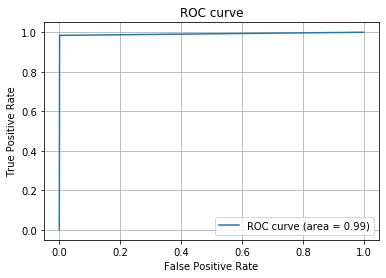

In [41]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

y_pred_m = final_model.predict(X_fin)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_m)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [57]:
from sklearn.metrics import f1_score
print(f1_score(y, y_pred_m))

0.9904648390941597


### 10. スコアリングフェーズ  
#### 10-1. スコアリングフェーズ：スコアリング用のデータ読み出し

In [42]:
# csvファイルからの読み出し
dataset_s = pd.read_csv(test_file,
                          header=0,    # CSVデータの1行目が見出し(header)で有ることを指定。データは1行目が[0]
                          dtype=my_dtype)

# 1列目のID情報、推論対象は特徴量から削除
ID_s = dataset_s.iloc[:,[0]]    # 第０列はPassengerIDなので、IDとしてセット
X_s = dataset_s.drop(score_reject_items, axis=1)    # 1列目はID情報のため特徴量から削除

# 形状の確認
print('-----------------------------------')
print('Raw Shape: (%i, %i)' %dataset_s.shape)
print('X_s Shape: (%i, %i)' %X_s.shape)
print('-----------------------------------')
print(X_s.dtypes)
ID_s.join(X_s).head()

-----------------------------------
Raw Shape: (4500, 11)
X_s Shape: (4500, 10)
-----------------------------------
left                     float64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object


,index,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,1670,NaN,0.44,0.57,2,141,3,0,0,product_mng,medium
1,13378,NaN,0.55,0.96,3,194,3,0,0,product_mng,medium
2,10233,NaN,0.72,0.67,5,210,2,0,0,management,medium
3,4719,NaN,0.96,0.75,4,177,2,0,0,IT,low
4,7003,NaN,0.96,0.54,3,198,3,0,0,support,low


#### 10-2. スコアリングフェーズ：one-hot-encoding処理

In [43]:
X_ohe_s = pd.get_dummies(X_s,
                         dummy_na=True,
                         columns=ohe_columns)
print('X_ohe_s shape:(%i,%i)' % X_ohe_s.shape)
X_ohe_s.head(3)

X_ohe_s shape:(4500,23)


,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan
0,NaN,0.44,0.57,2,141,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,NaN,0.55,0.96,3,194,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,NaN,0.72,0.67,5,210,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


#### 10-3. スコアリングフェーズ：one-hot encoding後のデータ整合チェック

In [44]:
cols_model= set(X_ohe.columns.values)
cols_score = set(X_ohe_s.columns.values)

diff1 = cols_model - cols_score
print('モデル用データのみに存在する項目: %s' %diff1)

diff2 = cols_score - cols_model
print('スコア用データのみに存在する項目: %s' %diff2)

モデル用データのみに存在する項目: set()
スコア用データのみに存在する項目: {'left'}


#### 10-4. スコアリングフェーズ：one-hot-encoding後のデータ不整合の解消

##### 不整合解消のための基本指針
- モデル用にはあるが、スコア用に存在しない変数は復活させる
- スコア用データにあるが、モデル用に存在しない変数は削除する

In [45]:
dataset_cols_m = pd.DataFrame(None,    # 空のデータ
                         columns=X_ohe_columns,# モデリング時のone-hot-encoding後のカラム構成
                         dtype=float)
display(dataset_cols_m)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan


In [46]:
X_ohe_s = pd.concat([dataset_cols_m, X_ohe_s])
print(X_ohe_s.shape)
display(X_ohe_s.head(3))

(4500, 23)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan,left
0,0.44,0.57,2.0,141.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
1,0.55,0.96,3.0,194.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
2,0.72,0.67,5.0,210.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN


スコアリングデータのみに登場する変数を削除する

In [47]:
set_Xm = set(X_ohe.columns.values)
set_Xs = set(X_ohe_s.columns.values)
print(set_Xs-set_Xm)
X_ohe_s = X_ohe_s.drop(list(set_Xs-set_Xm),axis=1)

print(X_ohe_s.shape)
display(X_ohe_s.head(3))

{'left'}
(4500, 22)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan
0,0.44,0.57,2.0,141.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.55,0.96,3.0,194.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.72,0.67,5.0,210.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


スコアリングでは登場しなかったデータ項目をゼロで埋める

In [48]:
print(set_Xm-set_Xs)
X_ohe_s.loc[:,list(set_Xm-set_Xs)] = X_ohe_s.loc[:,list(set_Xm-set_Xs)].fillna(0,axis=1)
X_ohe_s.head(3)

set()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,sales_nan,salary_high,salary_low,salary_medium,salary_nan
0,0.44,0.57,2.0,141.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.55,0.96,3.0,194.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.72,0.67,5.0,210.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### 10-5. スコアリングフェーズ:データ項目の並び順の担保
モデリング時点のデータ項目の並び順を明示的に担保する  
reindex関数を使うことで並び順を制御できます。

In [49]:
X_ohe_s = X_ohe_s.reindex(X_ohe_columns, axis=1)
X_ohe_s.head(3)
print(X_ohe_s.shape)

(4500, 22)


#### 10-6. スコアリングフェーズ：欠損値処理
ここまで整合させてようやく、学習済みSimpleImputerインスタンスが適用可能となる

In [50]:
print('欠損個数（数値変数の欠損補完前）',X_ohe_s.isnull().sum().sum())    # rowをsum()して、columnをsum()する

# (重要)モデリングデータで作ったimpを使ってtransformする
# もしここで改めてimpしたら、改めて計算されてしまう。そのためモデリングデータで使った平均値データを使ってtransformする
X_ohe_s = pd.DataFrame(imp.transform(X_ohe_s),columns=X_ohe_columns)

print('欠損個数（数値変数の欠損補完後）',X_ohe_s.isnull().sum().sum())

欠損個数（数値変数の欠損補完前） 0
欠損個数（数値変数の欠損補完後） 0


####  10-7. スコアリングフェーズ：次元圧縮、特徴量選択
学習済みのRFEクラスのインスタンス（本ファイルではselector）を使って、選択された特徴量のインデックスを指定する。

In [51]:
len(selector.support_)

22

In [52]:
X_fin_s = X_ohe_s.loc[:, X_ohe_columns[selector.support_]]
print(X_fin_s.shape)
X_fin_s.head(3)

(4500, 15)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,sales_IT,sales_RandD,sales_accounting,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.44,0.57,2.0,141.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.55,0.96,3.0,194.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.72,0.67,5.0,210.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
print('-----------------------------------')
print('X_fin_s shape: (%i,%i)' %X_fin_s.shape)
print('-----------------------------------')

-----------------------------------
X_fin_s shape: (4500,15)
-----------------------------------


### 11. 推論

In [54]:
y_pred = final_model.predict(X_fin_s)

In [55]:
len(y_pred)

4500

### 12. 提出用データ(CSVファイル)の作成

In [56]:
result_for_submit = pd.DataFrame({ID_column:dataset_s[ID_column], target_value:y_pred})

# 提出用のファイル格納用のディレクトリ を作成
os.makedirs(submit_file_dir, exist_ok=True)
result_for_submit.to_csv(submit_file_dir+submit_file_name, index=False)